## DAILY DATA BASED TRAINING

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import pickle
import matplotlib.pyplot as plt

def create_comprehensive_autoencoder(input_dim):
    """
    Create a comprehensive autoencoder to handle multiple features
    
    Parameters:
    - input_dim: Number of input features
    
    Returns:
    - Compiled autoencoder model
    """
    # Input layer
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    
    # Encoder with multiple layers and increasing complexity
    encoded = tf.keras.layers.Dense(
        max(input_dim, 64),  # Increased base layer size
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(input_layer)
    
    # Batch normalization for stability
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    
    # Additional hidden layers with decreasing dimensions
    encoded = tf.keras.layers.Dense(
        max(input_dim // 2, 32),  
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(encoded)
    
    # Batch normalization
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    
    # Bottleneck layer
    bottleneck = tf.keras.layers.Dense(
        max(input_dim // 4, 16),  # Tight bottleneck
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(encoded)
    
    # Decoder with symmetric architecture
    decoded = tf.keras.layers.Dense(
        max(input_dim // 2, 32), 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(bottleneck)
    
    # Batch normalization
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    
    decoded = tf.keras.layers.Dense(
        max(input_dim, 64), 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(decoded)
    
    # Final reconstruction layer
    decoded = tf.keras.layers.Dense(
        input_dim, 
        activation='linear'
    )(decoded)
    
    # Create autoencoder
    autoencoder = tf.keras.Model(input_layer, decoded)
    
    # Compile with adaptive optimizer
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001, 
            clipnorm=1.0  # Gradient clipping for stability
        ),
        loss='mean_squared_error'
    )
    
    return autoencoder

def plot_training_history(history):
    """
    Generate and save a plot of training and validation loss
    
    Parameters:
    - history: Model training history
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Autoencoder Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.tight_layout()
    
    # Ensure models directory exists
    os.makedirs("models", exist_ok=True)
    
    # Save the plot
    plt.savefig('models/training_loss_plot.png')
    plt.close()

def iqr_outlier_removal(data, columns):
    """
    Remove outliers using Interquartile Range (IQR) method
    
    Parameters:
    - data: DataFrame to clean
    - columns: List of columns to apply IQR cleaning
    
    Returns:
    - Cleaned DataFrame
    """
    cleaned_data = data.copy()
    
    for column in columns:
        # Calculate Q1, Q3, and IQR
        Q1 = cleaned_data[column].quantile(0.05)
        Q3 = cleaned_data[column].quantile(0.95)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 0.1 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        cleaned_data = cleaned_data[
            (cleaned_data[column] >= lower_bound) & 
            (cleaned_data[column] <= upper_bound)
        ]
        
        print(f"\nOutlier Cleaning for {column}:")
        print(f"  Q1: {Q1:.4f}")
        print(f"  Q3: {Q3:.4f}")
        print(f"  IQR: {IQR:.4f}")
        print(f"  Lower Bound: {lower_bound:.4f}")
        print(f"  Upper Bound: {upper_bound:.4f}")
        print(f"  Removed Rows: {len(data) - len(cleaned_data)}")
    
    return cleaned_data

def advanced_data_preprocessing(data):
    """
    Comprehensive data preprocessing pipeline
    
    Parameters:
    - data: Original DataFrame
    
    Returns:
    - Preprocessed DataFrame
    """
    # Select relevant columns
    relevant_columns = [
        'MO','ALLSKY_SFC_SW_DWN', 'T2M', 'T2MDEW', 'T2M_RANGE', 
        'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M', 'PRECTOTCORR', 
        'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
        'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'NDVI', 'CI', 'ELEVATION'
    ]
    
    # Initial data cleaning
    cleaned_data = data[relevant_columns].copy()
    
    # Convert to numeric and handle errors
    cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')
    
    # Remove rows with NaN values
    cleaned_data = cleaned_data.dropna()
    
    # IQR Outlier Removal
    cleaned_data = iqr_outlier_removal(cleaned_data, relevant_columns)
    
    # Additional preprocessing steps
    def additional_cleaning(df):
        # Remove extreme outliers (6 standard deviations)
        for column in df.columns:
            mean = df[column].mean()
            std = df[column].std()
            df = df[
                (df[column] >= mean - 6*std) & 
                (df[column] <= mean + 6*std)
            ]
        return df
    
    cleaned_data = additional_cleaning(cleaned_data)
    
    # Descriptive statistics before and after cleaning
    print("\n--- Data Cleaning Summary ---")
    print(f"Original Data Rows: {len(data)}")
    print(f"Cleaned Data Rows: {len(cleaned_data)}")
    print(f"Rows Removed: {len(data) - len(cleaned_data)}")
    
    # Visualization of data distribution before and after cleaning
    def plot_distribution_comparison(original, cleaned, columns):
        plt.figure(figsize=(20, 15))
        for i, column in enumerate(columns, 1):
            plt.subplot(5, 4, i)
            plt.hist(original[column], bins=50, alpha=0.5, label='Original')
            plt.hist(cleaned[column], bins=50, alpha=0.5, label='Cleaned')
            plt.title(column)
            plt.legend()
        plt.tight_layout()
        plt.savefig('distribution_comparison.png')
        plt.close()
    
    plot_distribution_comparison(data[relevant_columns], cleaned_data, relevant_columns)
    
    return cleaned_data


def train_comprehensive_anomaly_model(data):
    """
    Train a comprehensive anomaly detection model using all relevant features
    
    Parameters:
    - data: Full dataset
    
    Returns:
    - Dictionary with model and scaler
    """
    try:
        # Ensure models directory exists
        os.makedirs("models", exist_ok=True)

        # Select all relevant columns
        relevant_columns = [
            'MO', 'ALLSKY_SFC_SW_DWN', 'T2M', 'T2MDEW', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN',
            'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
            'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'NDVI', 'CI', 'ELEVATION'
        ]
        
        feature_data = advanced_data_preprocessing(data)
        
        # Convert to numeric and handle errors
        feature_data = feature_data.apply(pd.to_numeric, errors='coerce')
        
        # Skip if insufficient data
        if len(feature_data) < 500:  # Increased minimum samples
            print("Insufficient data for comprehensive model")
            return None
        
        # Scale the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(feature_data.values)
        
        # Split data (90% train, 10% test)
        X_train, X_test = train_test_split(X_scaled, test_size=0.1, random_state=42)
        
        # Create and train autoencoder
        input_dim = X_scaled.shape[1]
        autoencoder = create_comprehensive_autoencoder(input_dim)
        
        # Advanced callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=20, 
            restore_best_weights=True,
            min_delta=0.0001
        )
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=10, 
            min_lr=0.00001
        )
        
        # Train the model
        history = autoencoder.fit(
            X_train, X_train,
            epochs=250,  # Increased epochs
            batch_size=64,
            shuffle=True,
            validation_data=(X_test, X_test),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Plot training history
        plot_training_history(history.history)

        # Compute reconstruction error for each sample
        train_pred = autoencoder.predict(X_train)
        test_pred = autoencoder.predict(X_test)
        
        train_mse = np.mean(np.power(X_train - train_pred, 2), axis=1)
        test_mse = np.mean(np.power(X_test - test_pred, 2), axis=1)
        
        # Print reconstruction statistics
        print("Training Reconstruction Error:")
        print(f"Mean: {np.mean(train_mse)}")
        print(f"Std: {np.std(train_mse)}")
        print(f"Max: {np.max(train_mse)}")
        
        print("\nTesting Reconstruction Error:")
        print(f"Mean: {np.mean(test_mse)}")
        print(f"Std: {np.std(test_mse)}")
        print(f"Max: {np.max(test_mse)}")

        # Save comprehensive model
        model_path = "models/comprehensive_autoencoder.keras"
        autoencoder.save(model_path)

        # Save scaler using pickle
        scaler_path = "models/comprehensive_scaler.pkl"
        with open(scaler_path, "wb") as f:
            pickle.dump(scaler, f)

        print(f"Saved comprehensive model to {model_path}")
        print (f"Saved scaler to {scaler_path}")
        
        return {
            'autoencoder': autoencoder,
            'scaler': scaler,
            'history': history.history,
            'train_mse': train_mse,
            'test_mse': test_mse
        }
    
    except Exception as e:
        print(f"Error training comprehensive model: {e}")
        return None

def main():
    """
    Train a comprehensive anomaly detection model
    
    Returns:
    - Trained comprehensive model
    """
    # Load your dataset
    df = pd.read_excel("./data/train.xlsx")
    
    # Remove rows with any empty values
    df = df.dropna()
    
    # Train comprehensive model
    comprehensive_model = train_comprehensive_anomaly_model(df)
    
    return comprehensive_model

if __name__ == "__main__":
    main()


Outlier Cleaning for MO:
  Q1: 1.0000
  Q3: 12.0000
  IQR: 11.0000
  Lower Bound: -0.1000
  Upper Bound: 28.5000
  Removed Rows: 0

Outlier Cleaning for ALLSKY_SFC_SW_DWN:
  Q1: 2.2200
  Q3: 6.1500
  IQR: 3.9300
  Lower Bound: 1.8270
  Upper Bound: 12.0450
  Removed Rows: 2911

Outlier Cleaning for T2M:
  Q1: 12.1900
  Q3: 29.0500
  IQR: 16.8600
  Lower Bound: 10.5040
  Upper Bound: 54.3400
  Removed Rows: 6438

Outlier Cleaning for T2MDEW:
  Q1: 7.6700
  Q3: 25.4500
  IQR: 17.7800
  Lower Bound: 5.8920
  Upper Bound: 52.1200
  Removed Rows: 9185

Outlier Cleaning for T2M_RANGE:
  Q1: 5.2500
  Q3: 15.1800
  IQR: 9.9300
  Lower Bound: 4.2570
  Upper Bound: 30.0750
  Removed Rows: 11052

Outlier Cleaning for T2M_MAX:
  Q1: 19.6700
  Q3: 34.3900
  IQR: 14.7200
  Lower Bound: 18.1980
  Upper Bound: 56.4700
  Removed Rows: 13536

Outlier Cleaning for T2M_MIN:
  Q1: 9.8600
  Q3: 25.7600
  IQR: 15.9000
  Lower Bound: 8.2700
  Upper Bound: 49.6100
  Removed Rows: 14339

Outlier Cleaning for Q

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

class FeatureOptimizer:
    def __init__(self, model_path='models/comprehensive_autoencoder.keras', 
                 scaler_path='models/comprehensive_scaler.pkl'):
        """
        Initialize the FeatureOptimizer with pre-trained model and scaler
        
        Parameters:
        - model_path: Path to saved Keras model
        - scaler_path: Path to saved StandardScaler
        """
        # Load the trained model
        self.autoencoder = tf.keras.models.load_model(model_path)
        
        # Load the scaler
        with open(scaler_path, 'rb') as f:
            self.scaler = pickle.load(f)
        
        # Feature names (ensure this matches the order in your original preprocessing)
        self.feature_names = [
            'MO', 'ALLSKY_SFC_SW_DWN', 'T2M', 'T2MDEW', 'T2M_RANGE', 
            'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M', 'PRECTOTCORR', 
            'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
            'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'NDVI', 'CI', 'ELEVATION'
        ]

    def analyze_feature_importance(self, data):
        """
        Analyze the importance of each feature in reconstruction
        
        Parameters:
        - data: Input data DataFrame
        
        Returns:
        - Dictionary of feature importances
        """
        # Preprocess the data
        X_scaled = self.scaler.transform(data[self.feature_names].values)
        
        # Get reconstructed data
        X_reconstructed = self.autoencoder.predict(X_scaled)
        
        # Calculate reconstruction error for each feature
        feature_errors = {}
        for i, feature in enumerate(self.feature_names):
            # Calculate mean squared error for this feature
            feature_mse = np.mean((X_scaled[:, i] - X_reconstructed[:, i])**2)
            feature_errors[feature] = feature_mse
        
        # Sort features by reconstruction error
        sorted_features = sorted(feature_errors.items(), key=lambda x: x[1], reverse=True)
        
        return dict(sorted_features)

    def find_optimal_feature_ranges(self, data):
        """
        Find optimal ranges for features based on reconstruction error
        
        Parameters:
        - data: Input data DataFrame
        
        Returns:
        - Dictionary of optimal feature ranges
        """
        # Preprocess the data
        X_scaled = self.scaler.transform(data[self.feature_names].values)
        
        # Get reconstructed data
        X_reconstructed = self.autoencoder.predict(X_scaled)
        
        # Calculate reconstruction error
        reconstruction_errors = np.mean(np.power(X_scaled - X_reconstructed, 2), axis=1)
        
        # Find optimal ranges
        optimal_ranges = {}
        for i, feature in enumerate(self.feature_names):
            # Original data
            original_data = data[feature]
            
            # Find indices of low reconstruction error (good samples)
            low_error_mask = reconstruction_errors < np.percentile(reconstruction_errors, 25)
            
            # Calculate optimal range for this feature
            optimal_range = {
                'min': original_data[low_error_mask].min(),
                'max': original_data[low_error_mask].max(),
                'mean': original_data[low_error_mask].mean(),
                'median': original_data[low_error_mask].median(),
                'std': original_data[low_error_mask].std()
            }
            
            optimal_ranges[feature] = optimal_range
        
        return optimal_ranges

    def visualize_feature_distributions(self, data):
        """
        Create visualizations of feature distributions
        
        Parameters:
        - data: Input data DataFrame
        """
        # Preprocess the data
        X_scaled = self.scaler.transform(data[self.feature_names].values)
        
        # Get reconstructed data
        X_reconstructed = self.autoencoder.predict(X_scaled)
        
        # Calculate reconstruction error
        reconstruction_errors = np.mean(np.power(X_scaled - X_reconstructed, 2), axis=1)
        
        # Create plots
        plt.figure(figsize=(20, 15))
        for i, feature in enumerate(self.feature_names, 1):
            plt.subplot(5, 4, i)
            
            # Scatter plot of original vs reconstructed with error color
            plt.scatter(
                data[feature], 
                X_reconstructed[:, i-1], 
                c=reconstruction_errors, 
                cmap='viridis'
            )
            plt.title(feature)
            plt.xlabel('Original')
            plt.ylabel('Reconstructed')
        
        plt.tight_layout()
        plt.savefig('feature_reconstruction_analysis.png')
        plt.close()

    def generate_comprehensive_report(self, data):
        """
        Generate a comprehensive report of feature analysis
        
        Parameters:
        - data: Input data DataFrame
        """
        # Feature Importance Analysis
        feature_importance = self.analyze_feature_importance(data)
        print("\n--- Feature Reconstruction Importance ---")
        for feature, error in feature_importance.items():
            print(f"{feature}: {error:.4f}")
        
        # Optimal Ranges
        optimal_ranges = self.find_optimal_feature_ranges(data)
        print("\n--- Optimal Feature Ranges ---")
        for feature, ranges in optimal_ranges.items():
            print(f"\n{feature}:")
            for key, value in ranges.items():
                print(f"  {key}: {value:.4f}")
        
        # Visualizations
        self.visualize_feature_distributions(data)
        
        return {
            'feature_importance': feature_importance,
            'optimal_ranges': optimal_ranges
        }

def main():
    # Load your dataset
    df = pd.read_excel("./data/train.xlsx")
    df = df.dropna()
    
    # Initialize Feature Optimizer
    optimizer = FeatureOptimizer()
    
    # Generate Comprehensive Report
    report = optimizer.generate_comprehensive_report(df)
    
    return report

if __name__ == "__main__":
    main()

3306/3306 ━━━━━━━━━━━━━━━━━━━━ 3s 741us/step

--- Feature Reconstruction Importance ---
PRECTOTCORR: 0.0478
T2MDEW: 0.0386
PS: 0.0351
NDVI: 0.0336
T2M_MAX: 0.0334
T2M: 0.0292
T2M_MIN: 0.0278
WS10M_MAX: 0.0260
ALLSKY_SFC_SW_DWN: 0.0108
WS50M_MIN: 0.0102
WS10M: 0.0095
WS10M_MIN: 0.0085
T2M_RANGE: 0.0081
RH2M: 0.0068
QV2M: 0.0061
CI: 0.0055
WS50M: 0.0046
ELEVATION: 0.0039
MO: 0.0035
WS50M_MAX: 0.0021
3306/3306 ━━━━━━━━━━━━━━━━━━━━ 2s 721us/step

--- Optimal Feature Ranges ---

MO:
  min: 1.0000
  max: 12.0000
  mean: 7.5846
  median: 10.0000
  std: 4.0799

ALLSKY_SFC_SW_DWN:
  min: 0.8300
  max: 7.6300
  mean: 4.3204
  median: 4.2700
  std: 0.9128

T2M:
  min: 11.9000
  max: 34.0200
  mean: 21.7333
  median: 21.0100
  std: 4.4351

T2MDEW:
  min: 4.9100
  max: 27.3900
  mean: 16.7779
  median: 15.6600
  std: 4.9718

T2M_RANGE:
  min: 1.9300
  max: 18.1800
  mean: 9.9704
  median: 10.0700
  std: 2.5433

T2M_MAX:
  min: 17.2500
  max: 40.1000
  mean: 27.3021
  median: 26.9600
  std: 3.8731



In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

def custom_percentile_rank(values, x):
    """
    Calculate percentile rank for a value or array
    """
    return np.array([np.sum(values <= val) / len(values) * 100 for val in x])

def calculate_similarity(new_place_data, training_data, scaler, weights, autoencoder):
    """
    Calculate similarity between new place data and training data using autoencoder
    
    Parameters:
    - new_place_data: Feature vector of the new place
    - training_data: Scaled feature matrix of training data
    - scaler: Fitted StandardScaler object
    - weights: List of feature weights
    - autoencoder: Trained autoencoder model
    
    Returns:
    - DataFrame with distances and indices of similar places
    """
    # Scale the new place data
    new_place_scaled = scaler.transform(new_place_data.values.reshape(1, -1))
    
    # Apply weights
    training_data_weighted = training_data * weights
    new_place_weighted = new_place_scaled * weights
    
    # Use autoencoder for feature extraction
    training_encoded = autoencoder.predict(training_data_weighted)
    new_place_encoded = autoencoder.predict(new_place_weighted)
    
    # Compute distances (Euclidean and Cosine Similarity) in encoded space
    euclidean_distances = np.linalg.norm(training_encoded - new_place_encoded, axis=1)
    cosine_similarities = cosine_similarity(new_place_encoded, training_encoded).flatten()
    
    # Compute percentile ranks
    euclidean_percentile = custom_percentile_rank(euclidean_distances, euclidean_distances)
    cosine_percentile = custom_percentile_rank(cosine_similarities, cosine_similarities)
    
    # Combine results into a DataFrame
    results = pd.DataFrame({
        'Euclidean_Distance': euclidean_distances,
        'Cosine_Similarity': cosine_similarities,
        'Euclidean_Percentile': euclidean_percentile,
        'Cosine_Percentile': cosine_percentile
    })
    
    return results

def visualize_similarity_distribution(similarity_results, new_place_data):
    """
    Create visualizations of similarity distributions
    """
    plt.figure(figsize=(15, 5))
    
    # Euclidean Distance Distribution
    plt.subplot(1, 3, 1)
    sns.histplot(similarity_results['Euclidean_Distance'], kde=True)
    plt.title('Euclidean Distance Distribution')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.axvline(x=similarity_results['Euclidean_Distance'].min(), color='r', linestyle='--', 
                label='Most Similar')
    plt.legend()
    
    # Cosine Similarity Distribution
    plt.subplot(1, 3, 2)
    sns.histplot(similarity_results['Cosine_Similarity'], kde=True)
    plt.title('Cosine Similarity Distribution')
    plt.xlabel('Similarity')
    plt.ylabel('Frequency')
    plt.axvline(x=similarity_results['Cosine_Similarity'].max(), color='r', linestyle='--', 
                label='Most Similar')
    plt.legend()
    
    # Scatter plot of Euclidean vs Cosine
    plt.subplot(1, 3, 3)
    plt.scatter(similarity_results['Euclidean_Distance'], 
                similarity_results['Cosine_Similarity'], 
                alpha=0.5)
    plt.title('Euclidean Distance vs Cosine Similarity')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Cosine Similarity')
    
    plt.tight_layout()
    plt.savefig('models/similarity_analysis.png')
    plt.close()

def comprehensive_similarity_analysis(new_place_data, training_data, scaler, weights, autoencoder, euclidean_threshold, cosine_threshold):
    """
    Perform comprehensive similarity analysis with dissimilarity check
    """
    # Calculate similarity
    similarity_results = calculate_similarity(
        new_place_data, 
        scaler.transform(training_data.values), 
        scaler, 
        weights,
        autoencoder
    )
    
    # Check if the new place is dissimilar
    min_euclidean_distance = similarity_results['Euclidean_Distance'].min()
    max_cosine_similarity = similarity_results['Cosine_Similarity'].max()
    
    is_dissimilar = (
        min_euclidean_distance > euclidean_threshold or 
        max_cosine_similarity < cosine_threshold
    )
    
    # Find top similar places
    top_similar_euclidean = similarity_results.nsmallest(5, 'Euclidean_Distance')
    top_similar_cosine = similarity_results.nlargest(5, 'Cosine_Similarity')
    
    # Visualize similarity distribution
    visualize_similarity_distribution(similarity_results, new_place_data)
    
    # Detailed analysis
    analysis_results = {
        'new_place_data': new_place_data,
        'most_similar_euclidean': training_data.iloc[top_similar_euclidean.index],
        'most_similar_cosine': training_data.iloc[top_similar_cosine.index],
        'similarity_metrics': similarity_results,
        'is_dissimilar': is_dissimilar
    }
    
    return analysis_results

def main():
    """
    Compare a new place with training places for similarity and dissimilarity
    """
    # Load the scaler
    with open("models/comprehensive_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    
    # Load the autoencoder model
    model_path = "models/comprehensive_autoencoder.keras"
    autoencoder = tf.keras.models.load_model(model_path)
    
    # Load your training dataset
    training_data = pd.read_excel("./data/train.xlsx")
    
    # Filter and scale the training data
    relevant_columns = [
        'MO', 'ALLSKY_SFC_SW_DWN', 'T2M', 'T2MDEW', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN',
        'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
        'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'NDVI', 'CI', 'ELEVATION'
    ]
    training_features = training_data[relevant_columns].dropna()
    
    # Define weights
    weights = np.ones(len(relevant_columns))
    weights[relevant_columns.index('NDVI')] = 2.7  # Vegetation Density
    weights[relevant_columns.index('CI')] = 2.5    # Choloropyhll Index
    weights[relevant_columns.index('ELEVATION')] = 2.2  # Topographical Influence
    
    # Thresholds for similarity
    euclidean_threshold = 5.0
    cosine_threshold = 0.8
    
    # Load new places dataset
    new_places_data = pd.read_excel("./data/train_d.xlsx")
    
    # Select relevant columns, excluding the index and TARGET
    relevant_columns = [col for col in new_places_data.columns if col not in ['TARGET', 'Unnamed: 0']]
    new_places_data = new_places_data[relevant_columns].dropna()
    
    # Group by LAT and LON and calculate mean for other columns
    grouped_places = new_places_data .groupby(['LAT', 'LON','MO']).agg({
        col: 'mean' for col in new_places_data.columns 
        if col not in ['LAT', 'LON','MO']
    })

    # Reset index to make LAT and LON regular columns again
    grouped_places_reset = grouped_places.reset_index()

    output_results = []

    # Debug: Check the shape of the grouped DataFrame
    print(f"Number of unique LAT,LON combinations: {grouped_places_reset.shape[0]}")

    # Iterate through unique LAT,LON combinations
    for idx, grouped_place_data in grouped_places_reset.iterrows():
        try:
            # Print coordinates
            print(f"\nAnalyzing place for Month{grouped_place_data['MO']} with coordinates (LAT: {grouped_place_data['LAT']}, LON: {grouped_place_data['LON']})")
            
            # Ensure data is in the correct format
            new_place_data_for_analysis = grouped_place_data.drop(['LAT', 'LON','YEAR','DY'])

            # Convert the dictionary values into a pandas DataFrame (single row)
            place_data_df = pd.DataFrame(new_place_data_for_analysis).T
            
            # Calculate similarity and print results
            analysis_results = comprehensive_similarity_analysis(
                place_data_df, 
                training_features, 
                scaler, 
                weights, 
                autoencoder,
                euclidean_threshold, 
                cosine_threshold
            )

            # Store results
            output_results.append({
                'LAT': grouped_place_data['LAT'],
                'LON': grouped_place_data['LON'],
                'Month': grouped_place_data['MO'],
                'Is_Similar': not analysis_results['is_dissimilar'],
                'Cosine_Similarity': analysis_results['similarity_metrics']['Cosine_Similarity'].max(),
                'Euclidean_Distance': analysis_results['similarity_metrics']['Euclidean_Distance'].min()
            })

            # Print whether the place is dissimilar
            if analysis_results['is_dissimilar']:
                print(f"The place at LAT {grouped_place_data['LAT']}, LON {grouped_place_data['LON']} is **dissimilar** to the training set.")
            else:
                print(f"The place at LAT {grouped_place_data['LAT']}, LON {grouped_place_data['LON']} is similar to the training set.")
        
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            print(f"Problematic data: {grouped_place_data}")
            continue

        # Save all results to an Excel file
    output_df = pd.DataFrame(output_results)
    output_file = 'models/similarity_analysis_results.xlsx'
    output_df.to_excel(output_file, index=False)
    print(f"All results saved to {output_file}")

if __name__ == "__main__":
    main()

Number of unique LAT,LON combinations: 58

Analyzing place for Month12.0 with coordinates (LAT: -13.13, LON: -72.97)
3306/3306 ━━━━━━━━━━━━━━━━━━━━ 2s 702us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The place at LAT -13.13, LON -72.97 is **dissimilar** to the training set.

Analyzing place for Month8.0 with coordinates (LAT: -3.5, LON: -60.0)
3306/3306 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The place at LAT -3.5, LON -60.0 is **dissimilar** to the training set.

Analyzing place for Month1.0 with coordinates (LAT: -2.89, LON: -58.97)
3306/3306 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The place at LAT -2.89, LON -58.97 is similar to the training set.

Analyzing place for Month1.0 with coordinates (LAT: -2.25, LON: 10.75)
3306/3306 ━━━━━━━━━━━━━━━━━━━━ 2s 610us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The place at LAT -2.25, LON 10.75 is similar to the training set.

Analyzing place for Month3.0 with coordinates (LAT: 9.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_excel('./models/similarity_analysis_results.xlsx')

def categorize_similarity(row):
    # Define thresholds for Cosine Similarity and Euclidean Distance
    if row['Cosine_Similarity'] > 0.96 and row['Euclidean_Distance'] < 3.5:
        return 'Extremely Suitable for Hornbill'
    elif row['Cosine_Similarity'] > 0.93 and row['Euclidean_Distance'] < 4.5:
        return 'Ideal Suitable for Hornbill'
    elif row['Cosine_Similarity'] > 0.88 and row['Euclidean_Distance'] < 5.5:
        return 'Highly Suitable for Hornbill'
    elif row['Cosine_Similarity'] > 0.85 and row['Euclidean_Distance'] < 6.5:
        return 'Moderately Suitable for Hornbill'
    elif row['Cosine_Similarity'] > 0.80 and row['Euclidean_Distance'] < 7.5:
        return 'Less Suitability for Hornbill'
    elif row['Cosine_Similarity'] > 0.75 and row['Euclidean_Distance'] < 8.5:
        return 'Minimal Suitability for Hornbill'
    else:
        return 'unSuitable for Hornbill'


# Apply categorization to each row
df['Similarity_Category'] = df.apply(categorize_similarity, axis=1)

# Print locations with their similarity class
def print_locations_with_similarity(df):
    # Print the locations (LAT, LON) along with their similarity category
    location_similarity = df[['LAT', 'LON','Month', 'Similarity_Category']]
    print("\nLocations with Similarity Categories:")
    print(location_similarity)

# Visualization Function
def visualize_similarity_categories(df):
    # Plot a pie chart for the distribution of similarity categories
    plt.figure(figsize=(8, 8))
    similarity_distribution = df['Similarity_Category'].value_counts()
    similarity_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#99ff99', '#ff6666'])
    plt.title('Similarity Category Distribution')
    plt.tight_layout()
    plt.savefig('similarity_category_distribution_pie.png')
    plt.close()

    # Scatter plot of Cosine Similarity vs Euclidean Distance colored by similarity category
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Cosine_Similarity', y='Euclidean_Distance', hue='Similarity_Category', palette='coolwarm')
    plt.title('Cosine Similarity vs Euclidean Distance')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Euclidean Distance')
    plt.tight_layout()
    plt.savefig('cosine_vs_euclidean_similarity.png')
    plt.close()

    # Heatmap for geographical similarity (LAT vs LON) based on similarity category
    plt.figure(figsize=(10, 6))
    pivot_table = df.pivot_table(values='Cosine_Similarity', index='LAT', columns='LON', aggfunc='mean')
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, linewidths=0.5)
    plt.title('Geographical Similarity Heatmap')
    plt.tight_layout()
    plt.savefig('geographical_similarity_heatmap.png')
    plt.close()

# Main Execution
def main():
    # Print locations with their similarity class
    print_locations_with_similarity(df)
    
    # Visualize similarity categories
    visualize_similarity_categories(df)

if __name__ == "__main__":
    main()



Locations with Similarity Categories:
      LAT     LON  Month               Similarity_Category
0  -13.13  -72.97     12           unSuitable for Hornbill
1   -3.50  -60.00      8      Highly Suitable for Hornbill
2   -2.89  -58.97      1      Highly Suitable for Hornbill
3   -2.25   10.75      1       Ideal Suitable for Hornbill
4    9.26   77.11      3       Ideal Suitable for Hornbill
5   12.14  101.39      1       Ideal Suitable for Hornbill
6   12.14  101.39      2       Ideal Suitable for Hornbill
7   12.14  101.39      3       Ideal Suitable for Hornbill
8   12.14  101.39      4       Ideal Suitable for Hornbill
9   12.14  101.39      5       Ideal Suitable for Hornbill
10  12.14  101.39      6       Ideal Suitable for Hornbill
11  12.14  101.39      7   Extremely Suitable for Hornbill
12  12.14  101.39      8       Ideal Suitable for Hornbill
13  12.14  101.39      9      Highly Suitable for Hornbill
14  12.14  101.39     10      Highly Suitable for Hornbill
15  12.14  101.39

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

def calculate_feature_importance(data, target_feature):
    """
    Calculate feature importance using mutual information
    
    Parameters:
    - data: DataFrame with features
    - target_feature: Target column for importance calculation
    
    Returns:
    - Feature importance DataFrame
    """
    # Select numeric columns
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    
    # Prepare data
    X = data[numeric_columns].drop(columns=[target_feature])
    y = data[target_feature]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate mutual information
    mi_scores = mutual_info_regression(X_scaled, y)
    
    # Create importance DataFrame
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)
    
    return feature_importance

def plot_feature_importance(feature_importance):
    """
    Visualize feature importance
    
    Parameters:
    - feature_importance: DataFrame with feature importance scores
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=feature_importance.head(10), 
        palette='viridis'
    )
    plt.title('Top 10 Features by Importance')
    plt.xlabel('Mutual Information Score')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

# Usage
def feature_importance_analysis(df):
    # Analyze importance for different target features
    targets = ['T2M', 'PRECTOTCORR', 'NDVI']
    
    for target in targets:
        print(f"\nFeature Importance for {target}")
        importance = calculate_feature_importance(df, target)
        plot_feature_importance(importance)



In [11]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def perform_clustering(data, n_clusters=5, method='kmeans'):
    """
    Perform clustering analysis
    
    Parameters:
    - data: Input DataFrame
    - n_clusters: Number of clusters for K-means
    - method: Clustering method ('kmeans' or 'dbscan')
    
    Returns:
    - Cluster labels and visualization
    """
    # Prepare data
    numeric_columns = [
        'T2M', 'RH2M', 'WS10M', 'NDVI', 'CI', 
        'PRECTOTCORR', 'ELEVATION'
    ]
    X = data[numeric_columns]
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Clustering
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        labels = clusterer.fit_predict(X_scaled)
    else:
        clusterer = DBSCAN(eps=0.5, min_samples=5)
        labels = clusterer.fit_predict(X_scaled)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        X_pca[:, 0], X_pca[:, 1], 
        c=labels, 
        cmap='viridis'
    )
    plt.title(f'{method.upper()} Clustering Visualization')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.savefig(f'{method}_clustering.png')
    plt.show()
    
    # Cluster characteristics
    clustered_data = data.copy()
    clustered_data['Cluster'] = labels
    
    cluster_summary = clustered_data.groupby('Cluster')[numeric_columns].mean()
    print("\nCluster Characteristics:")
    print(cluster_summary)
    
    return labels, cluster_summary

# Usage
def clustering_analysis(df):
    # K-means clustering
    kmeans_labels, kmeans_summary = perform_clustering(df, method='kmeans')
    
    # DBSCAN clustering
    dbscan_labels, dbscan_summary = perform_clustering(df, method='dbscan')

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def temporal_similarity_analysis(df):
    """
    Analyze temporal variations in similarity
    
    Parameters:
    - df: Input DataFrame with temporal information
    
    Returns:
    - Temporal similarity insights
    """
    # Ensure month column exists
    if 'MO' not in df.columns:
        df['MO'] = pd.to_datetime(df['DATE']).dt.month
    
    # Select key features for temporal analysis
    features = [
        'T2M', 'RH2M', 'PRECTOTCORR', 
        'WS10M', 'NDVI', 'CI'
    ]
    
    # Monthly aggregation
    monthly_stats = df.groupby('MO')[features].agg(['mean', 'std'])
    
    # Visualization of monthly variations
    plt.figure(figsize=(15, 10))
    
    # Heatmap of monthly feature variations
    plt.subplot(2, 1, 1)
    monthly_means = df.groupby('MO')[features].mean()
    sns.heatmap(
        monthly_means.T, 
        cmap='YlGnBu', 
        annot=True, 
        fmt='.2f'
    )
    plt.title('Monthly Feature Variations')
    
    # Line plot of feature changes
    plt.subplot(2, 1, 2)
    monthly_means.plot(marker='o')
    plt.title('Monthly Feature Trends')
    plt.xlabel('Month')
    plt.ylabel('Feature Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('temporal_variations.png')
    plt.show()
    
    # Correlation between months
    monthly_correlation = monthly_means.T.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        monthly_correlation, 
        annot=True, 
        cmap='coolwarm', 
        center=0
    )
    plt.title('Monthly Feature Correlation')
    plt.tight_layout()
    plt.savefig('monthly_correlation.png')
    
    return monthly_stats, monthly_correlation

# Comprehensive Analysis Function
def comprehensive_data_analysis(df):
    """
    Perform comprehensive data analysis
    
    Parameters:
    - df: Input DataFrame
    """
    # 1. Feature Importance Analysis
    feature_importance_analysis(df)
    
    # 2. Clustering Analysis
    clustering_analysis(df)
    
    # 3. Temporal Variations
    temporal_stats, temporal_correlation = temporal_similarity_analysis(df)
    
    return {
        'feature_importance': feature_importance_analysis(df),
        'clustering': clustering_analysis(df),
        'temporal_stats': temporal_stats,
        'temporal_correlation': temporal_correlation
    }

# Usage
# results = comprehensive_data_analysis(your_dataframe)


Feature Importance for T2M


C:\Users\visha\AppData\Local\Temp\ipykernel_5672\1909458463.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


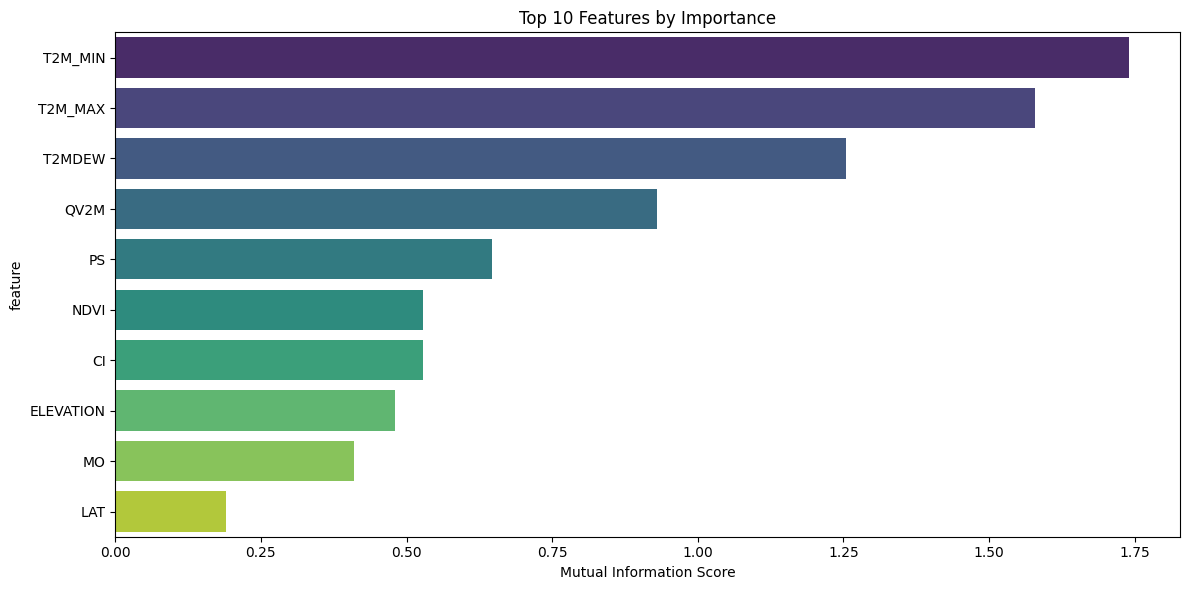


Feature Importance for PRECTOTCORR


C:\Users\visha\AppData\Local\Temp\ipykernel_5672\1909458463.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


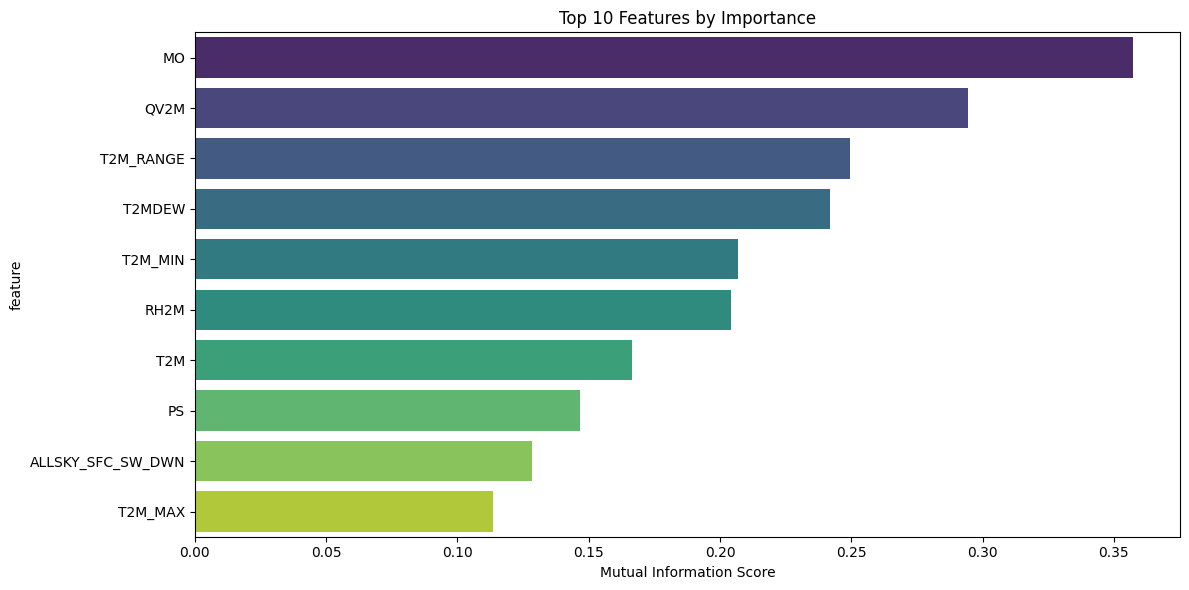


Feature Importance for NDVI


C:\Users\visha\AppData\Local\Temp\ipykernel_5672\1909458463.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


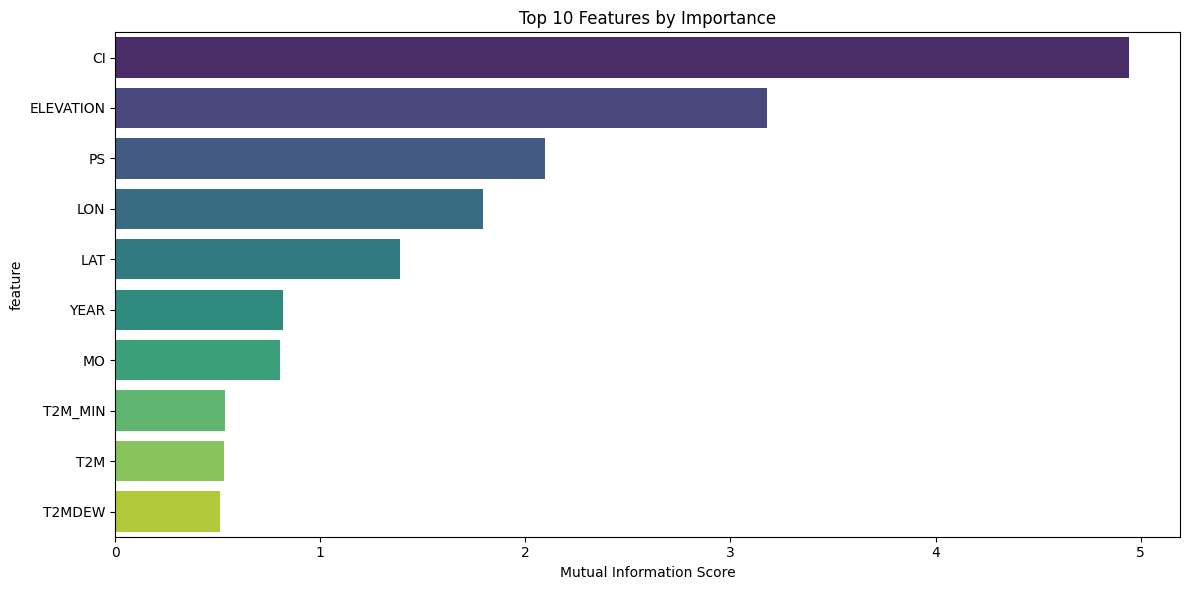

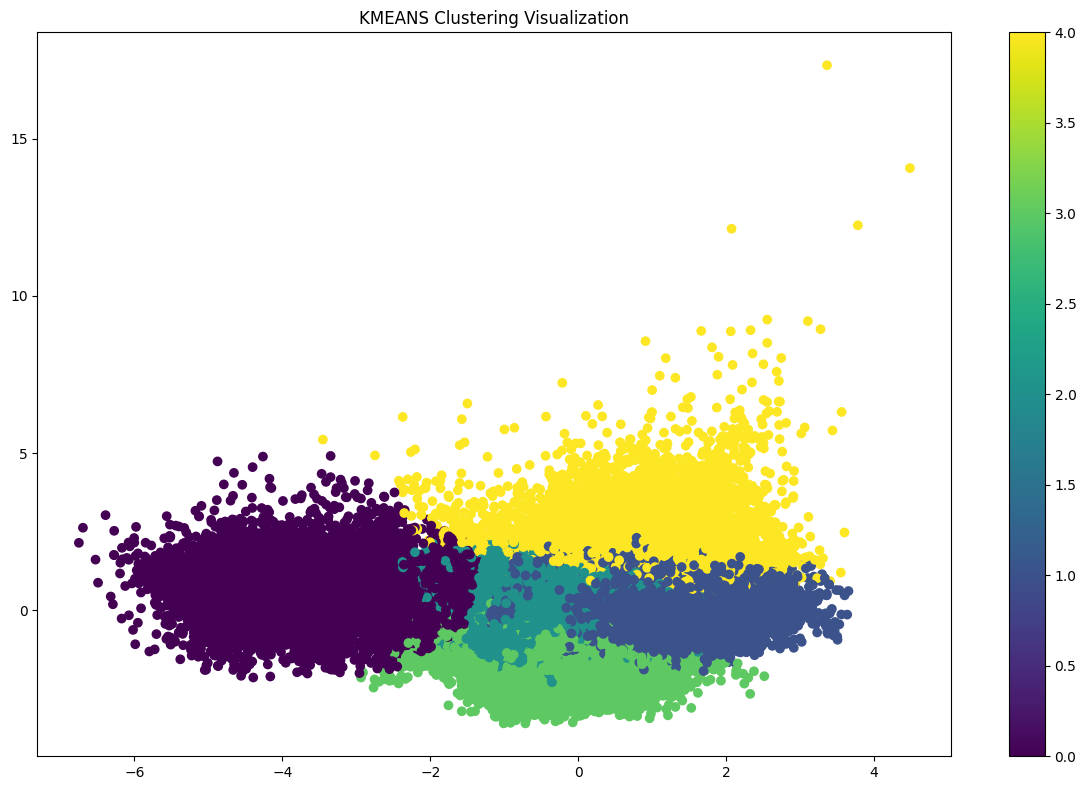


Cluster Characteristics:
               T2M       RH2M     WS10M      NDVI        CI  PRECTOTCORR  \
Cluster                                                                    
0         8.641952  81.480750  2.387893  0.191862 -0.045558     2.955549   
1        18.739628  79.812664  1.489286  0.771291  0.239676     2.511221   
2        24.049675  81.060541  1.659395  0.358089  0.038702     4.629203   
3        21.196232  63.952438  1.797100  0.491597  0.073672     0.865432   
4        23.958989  87.337154  2.130289  0.675129  0.187424    23.487658   

           ELEVATION  
Cluster               
0        3800.506000  
1        1025.317045  
2         138.295234  
3         305.840168  
4         758.704052  


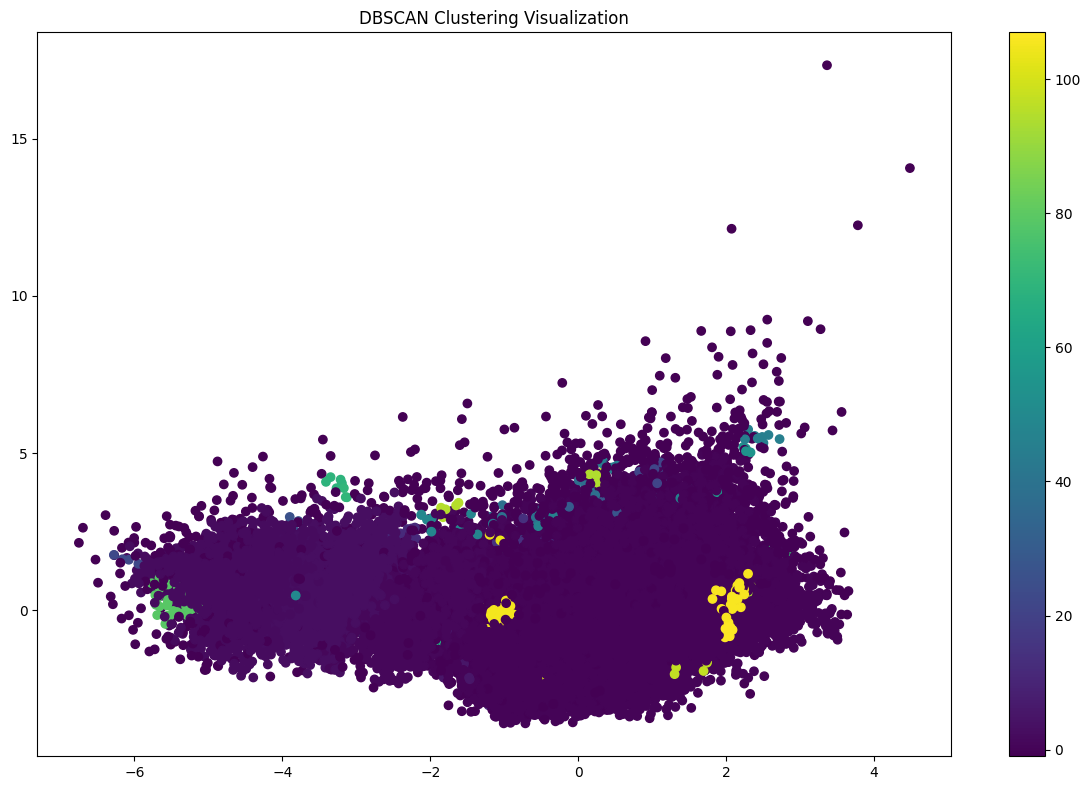


Cluster Characteristics:
               T2M       RH2M     WS10M      NDVI        CI  PRECTOTCORR  \
Cluster                                                                    
-1       20.788241  79.142998  2.474524  0.473093  0.109407    18.219895   
 0       21.285033  78.354492  1.630649  0.607008  0.151816     4.836616   
 1       13.913964  80.585868  1.890228  0.492404 -0.088418     3.173292   
 2        5.014080  80.896924  2.678152  0.014859 -0.051338     2.243442   
 3        8.097299  82.902418  2.449335  0.101673  0.000612     3.176192   
...            ...        ...       ...       ...       ...          ...   
 103     19.152222  72.328889  2.007778  0.501535  0.141649     0.495556   
 104     27.417500  83.607500  3.215000 -0.096778  0.007321    29.855000   
 105     13.909000  77.094000  1.611000  0.681038  0.041509     0.147500   
 106     10.920000  79.777273  1.556818  0.951106  0.666667     0.304545   
 107     11.217143  64.330000  1.578571  0.951106  0.666667   

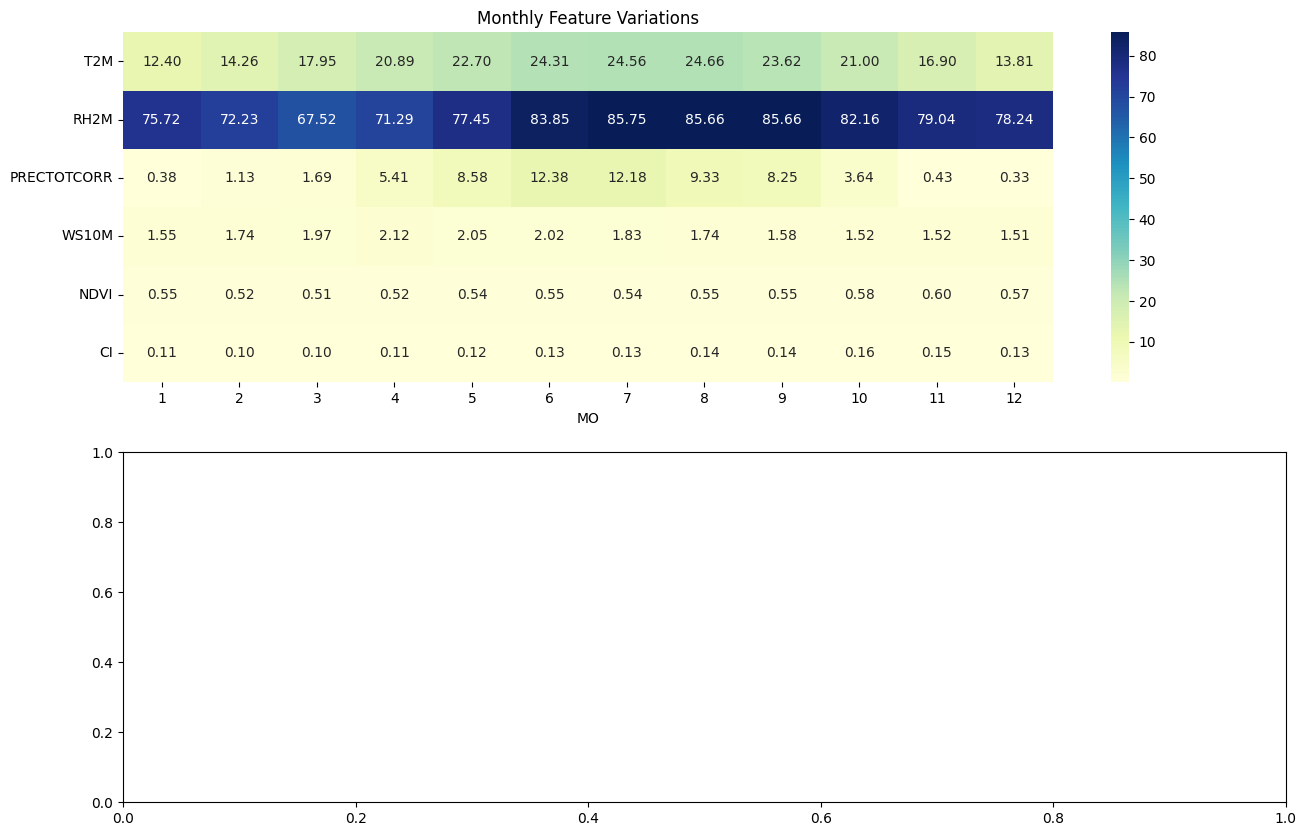

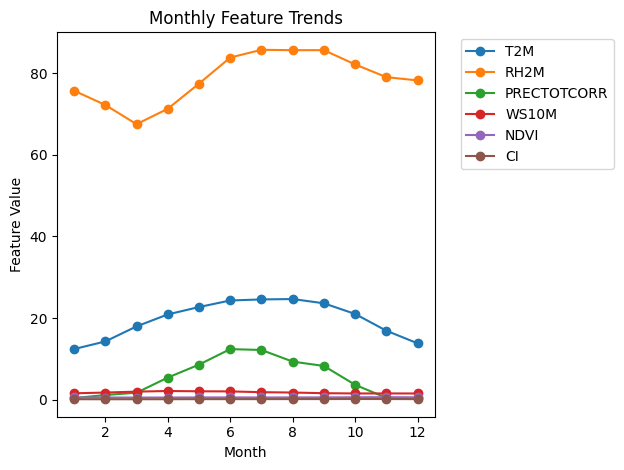


Feature Importance for T2M


C:\Users\visha\AppData\Local\Temp\ipykernel_5672\1909458463.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


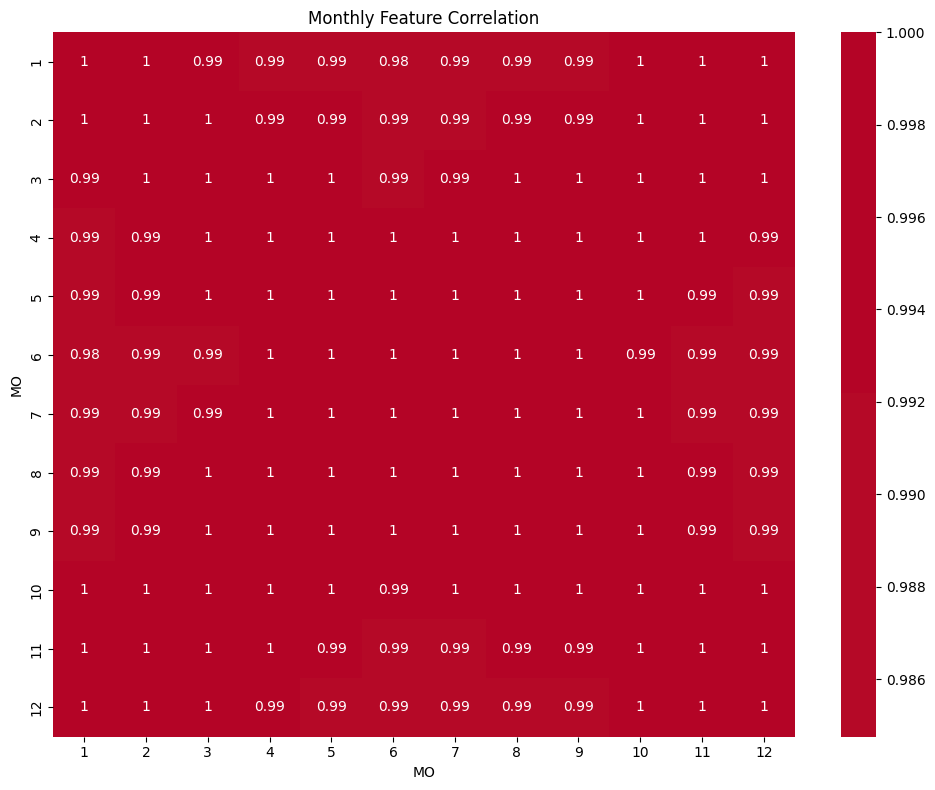

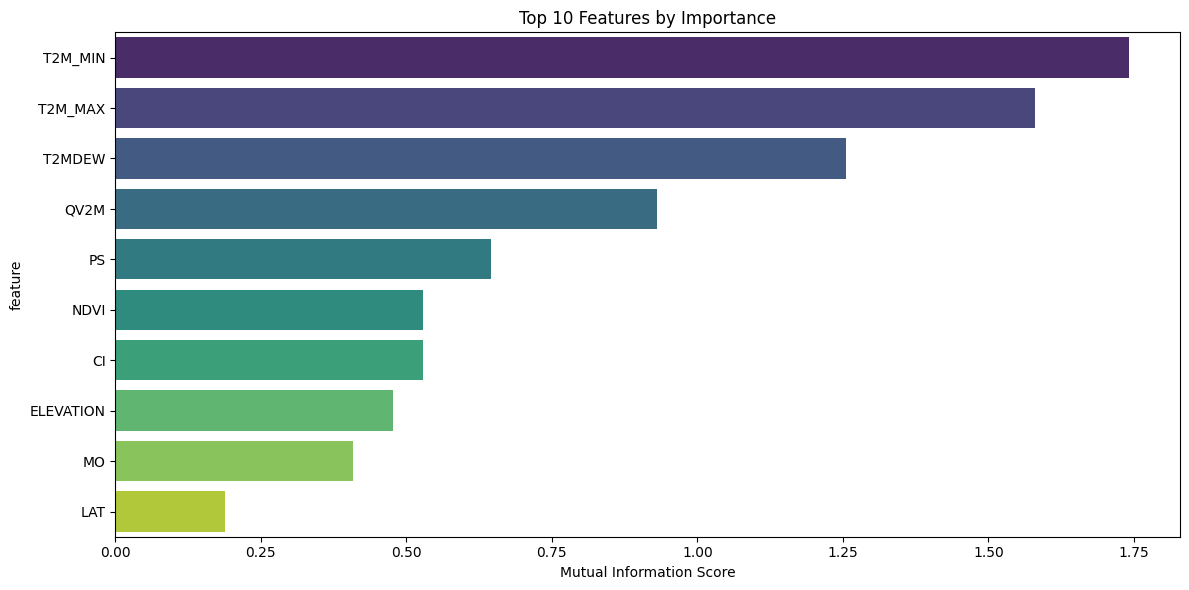


Feature Importance for PRECTOTCORR


C:\Users\visha\AppData\Local\Temp\ipykernel_5672\1909458463.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


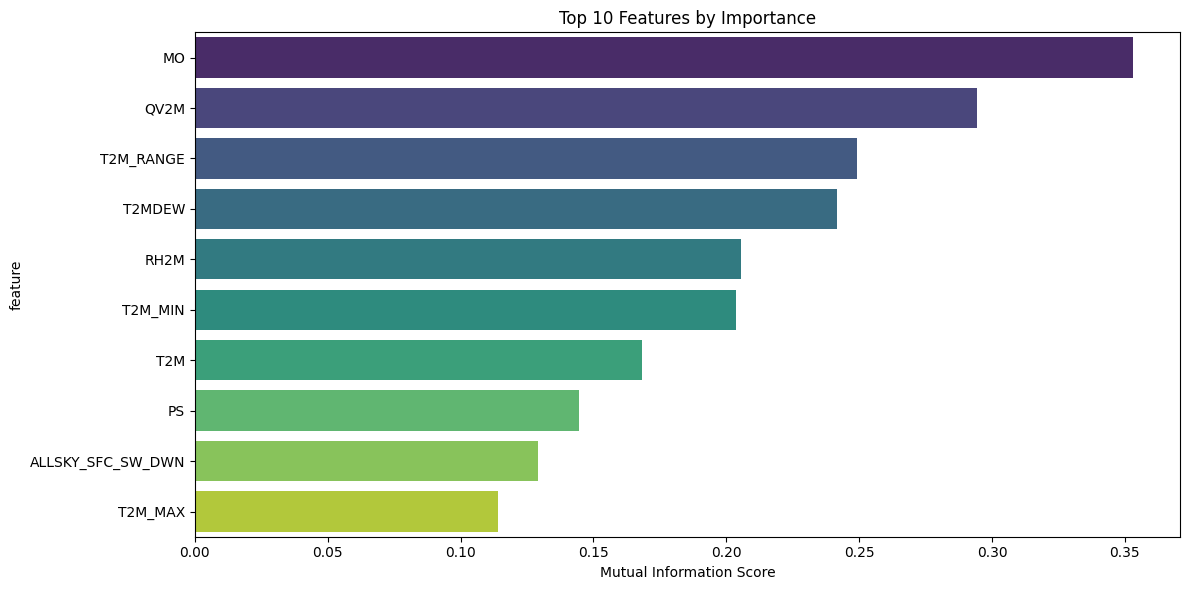


Feature Importance for NDVI


C:\Users\visha\AppData\Local\Temp\ipykernel_5672\1909458463.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


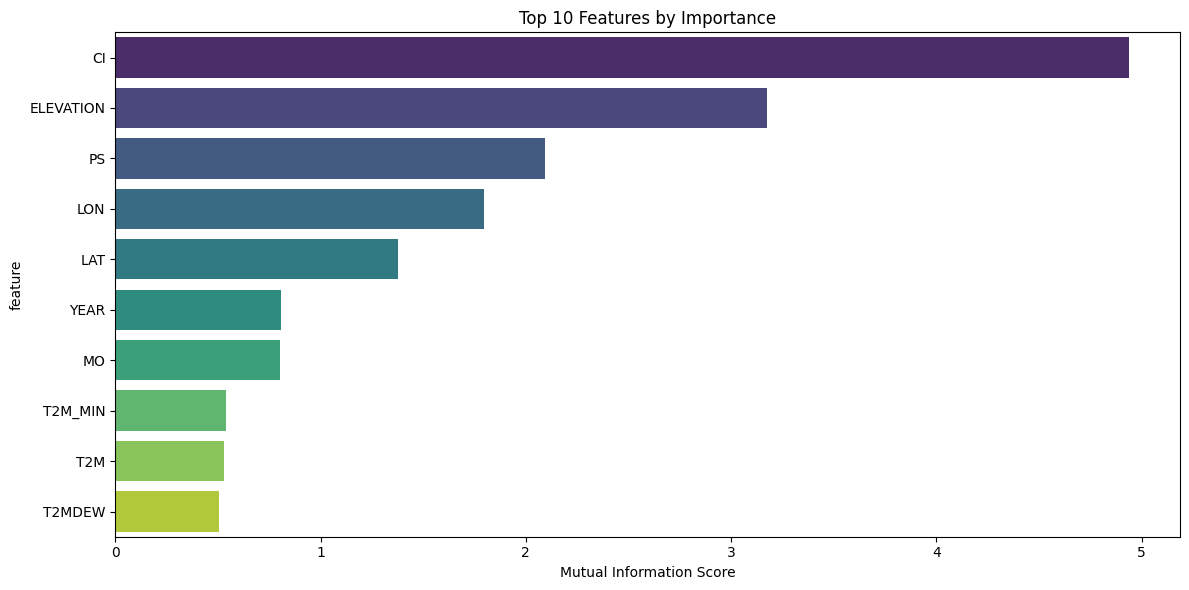

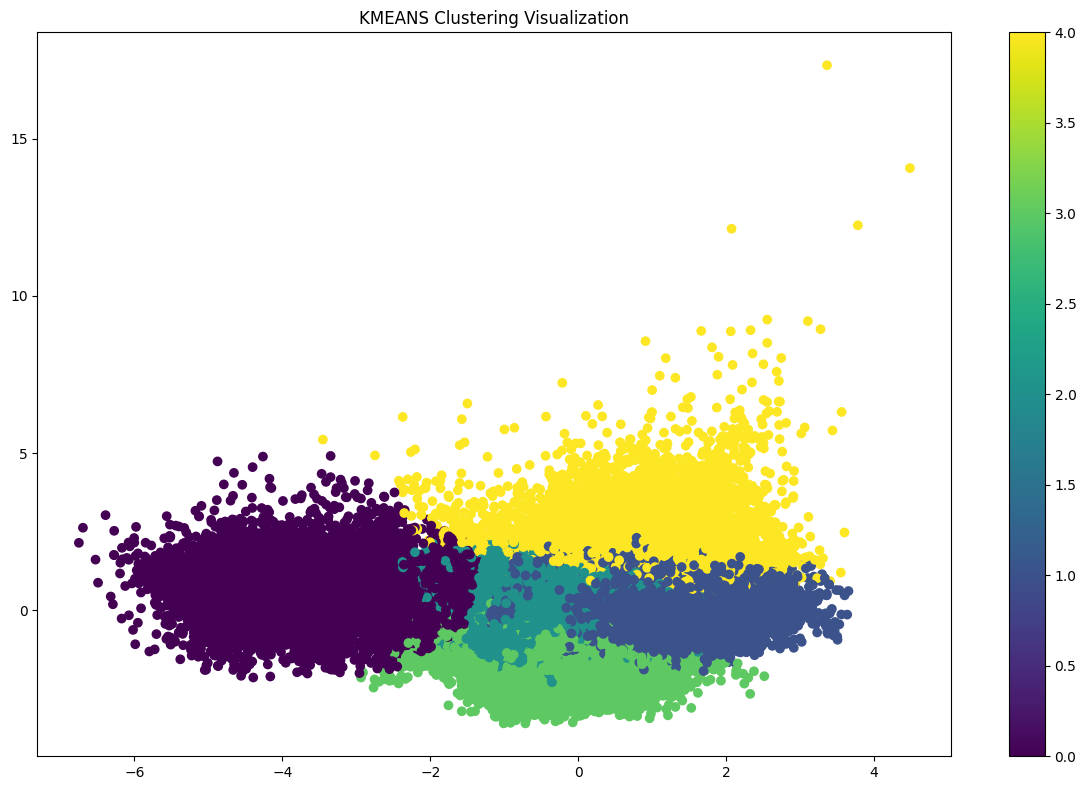


Cluster Characteristics:
               T2M       RH2M     WS10M      NDVI        CI  PRECTOTCORR  \
Cluster                                                                    
0         8.641952  81.480750  2.387893  0.191862 -0.045558     2.955549   
1        18.739628  79.812664  1.489286  0.771291  0.239676     2.511221   
2        24.049675  81.060541  1.659395  0.358089  0.038702     4.629203   
3        21.196232  63.952438  1.797100  0.491597  0.073672     0.865432   
4        23.958989  87.337154  2.130289  0.675129  0.187424    23.487658   

           ELEVATION  
Cluster               
0        3800.506000  
1        1025.317045  
2         138.295234  
3         305.840168  
4         758.704052  


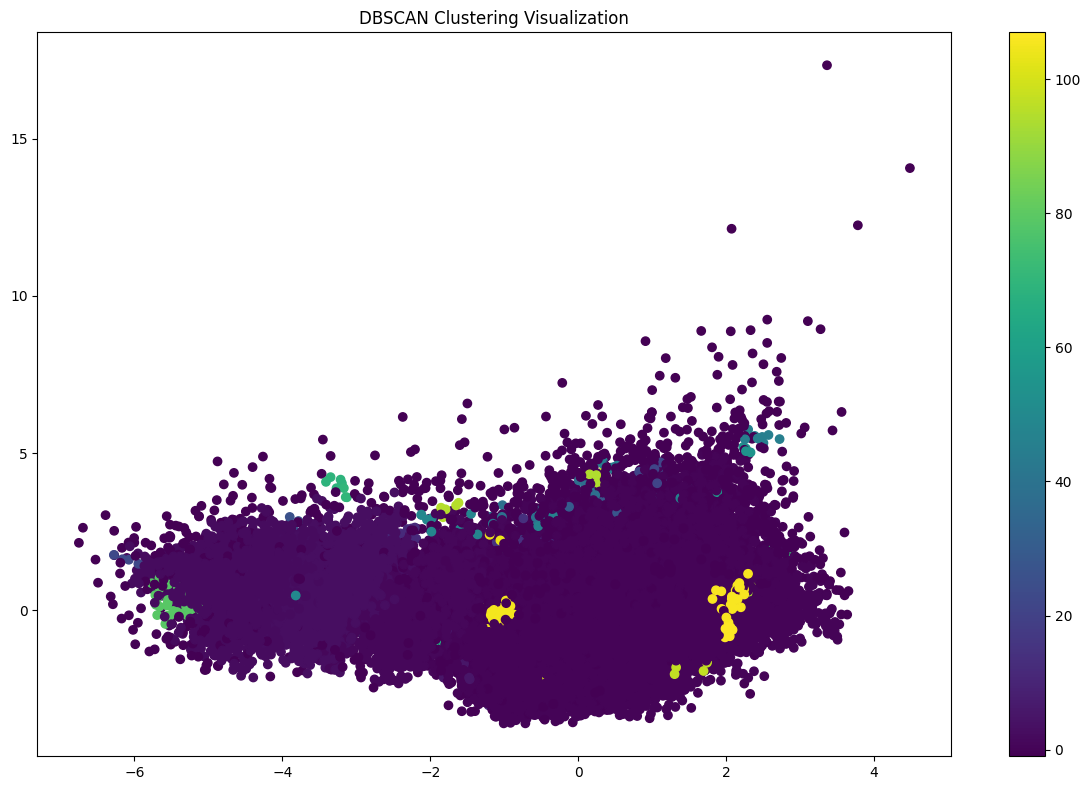


Cluster Characteristics:
               T2M       RH2M     WS10M      NDVI        CI  PRECTOTCORR  \
Cluster                                                                    
-1       20.788241  79.142998  2.474524  0.473093  0.109407    18.219895   
 0       21.285033  78.354492  1.630649  0.607008  0.151816     4.836616   
 1       13.913964  80.585868  1.890228  0.492404 -0.088418     3.173292   
 2        5.014080  80.896924  2.678152  0.014859 -0.051338     2.243442   
 3        8.097299  82.902418  2.449335  0.101673  0.000612     3.176192   
...            ...        ...       ...       ...       ...          ...   
 103     19.152222  72.328889  2.007778  0.501535  0.141649     0.495556   
 104     27.417500  83.607500  3.215000 -0.096778  0.007321    29.855000   
 105     13.909000  77.094000  1.611000  0.681038  0.041509     0.147500   
 106     10.920000  79.777273  1.556818  0.951106  0.666667     0.304545   
 107     11.217143  64.330000  1.578571  0.951106  0.666667   

In [15]:
def main():
    # Load your dataset
    df = pd.read_excel('./data/train.xlsx')  # Replace with your actual dataset path

    df=df.dropna()

    # Perform comprehensive data analysis
    results = comprehensive_data_analysis(df)

    # Save results or further process as needed
    print("Analysis complete. Results saved and visualized.")

if __name__ == "__main__":
    main()

## MONTH WISE AUTOENCODER


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import pickle
import matplotlib.pyplot as plt
import json

def create_month_specific_autoencoder(input_dim):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    
    # Encoder with multiple layers and increasing complexity
    encoded = tf.keras.layers.Dense(
        max(input_dim, 64),  
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(input_layer)
    
    # Batch normalization for stability
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    
    # Additional hidden layers with decreasing dimensions
    encoded = tf.keras.layers.Dense(
        max(input_dim // 2, 32),  
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(encoded)
    
    # Batch normalization
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    
    # Bottleneck layer
    bottleneck = tf.keras.layers.Dense(
        max(input_dim // 4, 16),  # Tight bottleneck
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(encoded)
    
    # Decoder with symmetric architecture
    decoded = tf.keras.layers.Dense(
        max(input_dim // 2, 32), 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(bottleneck)
    
    # Batch normalization
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    
    decoded = tf.keras.layers.Dense(
        max(input_dim, 64), 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(decoded)
    
    # Final reconstruction layer
    decoded = tf.keras.layers.Dense(
        input_dim, 
        activation='linear'
    )(decoded)
    
    # Create autoencoder
    autoencoder = tf.keras.Model(input_layer, decoded)
    
    # Compile with adaptive optimizer
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001, 
            clipnorm=1.0  # Gradient clipping for stability
        ),
        loss='mean_squared_error'
    )
    
    return autoencoder

def train_month_specific_models(data):
    # Ensure models directory exists
    os.makedirs("models/monthly_models", exist_ok=True)
    
    # Select all relevant columns
    relevant_columns = [
        'MO', 'ALLSKY_SFC_SW_DWN', 'T2M', 'T2MDEW', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN',
        'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
        'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'NDVI', 'CI', 'ELEVATION'
    ]
    
    # Store month-specific models and scalers
    month_models = {}
    
    # Train model for each month
    for month in range(1, 13):
        try:
            # Filter data for specific month
            month_data = data[data['MO'] == month][relevant_columns]
            
            # Convert to numeric and handle errors
            month_data = month_data.apply(pd.to_numeric, errors='coerce')
            month_data = month_data.dropna()
            
            # Skip if insufficient data
            if len(month_data) < 500:
                print(f"Insufficient data for Month {month}")
                continue
            
            # Scale the data
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(month_data.values)
            
            # Split data (90% train, 10% test)
            X_train, X_test = train_test_split(X_scaled, test_size=0.1, random_state=42)
            
            # Create and train month-specific autoencoder
            input_dim = X_scaled.shape[1]
            autoencoder = create_month_specific_autoencoder(input_dim)
            
            # Advanced callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=20, 
                restore_best_weights=True,
                min_delta=0.0001
            )
            
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.5, 
                patience=10, 
                min_lr=0.00001
            )
            
            # Train the model
            history = autoencoder.fit(
                X_train, X_train,
                epochs=250,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )

            # Plot training history
            plt.figure(figsize=(10, 6))
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f'Month {month} Autoencoder Model Training Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (Mean Squared Error)')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'models/monthly_models/month_{month}_training_loss_plot.png')
            plt.close()

            # Compute reconstruction error for each sample
            train_pred = autoencoder.predict(X_train)
            test_pred = autoencoder.predict(X_test)
            
            train_mse = np.mean(np.power(X_train - train_pred, 2), axis=1)
            test_mse = np.mean(np.power(X_test - test_pred, 2), axis=1)
            
            # Print reconstruction statistics
            print(f"Month {month} Training Reconstruction Error:")
            print(f"Mean: {np.mean(train_mse)}")
            print(f"Std: {np.std(train_mse)}")
            print(f"Max: {np.max(train_mse)}")
            
            print(f"\nMonth {month} Testing Reconstruction Error:")
            print(f"Mean: {np.mean(test_mse)}")
            print(f"Std: {np.std(test_mse)}")
            print(f"Max: {np.max(test_mse)}")

            # Save month-specific model
            model_path = f"models/monthly_models/month_{month}_autoencoder.keras"
            autoencoder.save(model_path)

            # Save scaler using pickle
            scaler_path = f"models/monthly_models/month_{month}_scaler.pkl"  # Removed extra space
            with open(scaler_path, "wb") as f:
                pickle.dump(scaler, f)

            print(f"Saved month-specific model to {model_path}")
            print(f"Saved scaler to {scaler_path}")
            
            month_models[month] = {
                'model': autoencoder,
                'scaler': scaler,
                'train_mse': train_mse,
                'test_mse': test_mse,
                'history': history.history
            }
        
        except Exception as e:
            print(f"Error training model for Month {month}: {e}")

    return month_models

def analyze_monthly_anomalies(data, month_models):
    """
    Analyze anomalies for each month
    
    Parameters:
    - data: Full dataset
    - month_models: Dictionary of month-specific models
    
    Returns:
    - Dictionary of monthly anomalies
    """
    monthly_anomalies = {}
    
    # Relevant columns (excluding month)
    relevant_columns = [
        'ALLSKY_SFC_SW_DWN', 'T2M', 'T2MDEW', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN',
        'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
        'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'NDVI', 'CI', 'ELEVATION'
    ]
    
    # Analyze each month
    for month in range(1, 13):
        if month not in month_models:
            continue
        
        # Get month-specific model and scaler
        month_model = month_models[month]['model']
        month_scaler = month_models[month]['scaler']# Filter data for specific month
        month_data = data[data['MO'] == month][relevant_columns]
        
        # Convert to numeric and handle errors
        month_data = month_data.apply(pd.to_numeric, errors='coerce').dropna()
        
        # Scale the data
        X_scaled = month_scaler.transform(month_data.values)
        
        # Compute reconstruction error
        reconstructed = month_model.predict(X_scaled)
        mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)
        
        # Store anomalies
        monthly_anomalies[month] = {
            'mse': mse,
            'threshold': np.percentile(mse, 95),  # Define threshold for anomalies
            'anomalies': month_data[mse > np.percentile(mse, 95)]
        }
        
        print(f"Analyzed anomalies for Month {month}: {len(monthly_anomalies[month]['anomalies'])} detected")

    return monthly_anomalies

def visualize_monthly_model_performance(month_models):
    """
    Create comprehensive visualization of monthly model performances
    
    Parameters:
    - month_models: Dictionary of trained month-specific models
    """
    # Ensure visualization directory exists
    os.makedirs('models/visualizations', exist_ok=True)
    
    # Prepare data for visualization
    months = list(month_models.keys())
    
    # 1. Training MSE Comparison
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    train_mse_means = [np.mean(month_models[month]['train_mse']) for month in months]
    train_mse_stds = [np.std(month_models[month]['train_mse']) for month in months]
    
    plt.bar(months, train_mse_means, yerr=train_mse_stds, capsize=5)
    plt.title('Average Training MSE by Month')
    plt.xlabel('Month')
    plt.ylabel('Mean Squared Error')
    plt.xticks(months)
    
    # 2. Testing MSE Comparison
    plt.subplot(2, 2, 2)
    test_mse_means = [np.mean(month_models[month]['test_mse']) for month in months]
    test_mse_stds = [np.std(month_models[month]['test_mse']) for month in months]
    
    plt.bar(months, test_mse_means, yerr=test_mse_stds, capsize=5, color='orange')
    plt.title('Average Testing MSE by Month')
    plt.xlabel('Month')
    plt.ylabel('Mean Squared Error')
    plt.xticks(months)
    
    # 3. Final Training Loss Comparison
    plt.subplot(2, 2, 3)
    final_train_losses = [month_models[month]['history']['loss'][-1] for month in months]
    
    plt.bar(months, final_train_losses, color='green')
    plt.title('Final Training Loss by Month')
    plt.xlabel('Month')
    plt.ylabel('Loss')
    plt.xticks(months)
    
    # 4. Final Validation Loss Comparison
    plt.subplot(2, 2, 4)
    final_val_losses = [month_models[month]['history']['val_loss'][-1] for month in months]
    
    plt.bar(months, final_val_losses, color='red')
    plt.title('Final Validation Loss by Month')
    plt.xlabel('Month')
    plt.ylabel('Loss')
    plt.xticks(months)
    
    plt.tight_layout()
    plt.savefig('models/visualizations/monthly_model_performance.png')
    plt.close()

    # Detailed Loss Progression Visualization
    plt.figure(figsize=(15, 10))
    for month in months:
        plt.plot(month_models[month]['history']['loss'], label=f'Month {month} Training Loss')
        plt.plot(month_models[month]['history']['val_loss'], label=f'Month {month} Validation Loss', linestyle='--')
    
    plt.title('Loss Progression for Each Month')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('models/visualizations/monthly_loss_progression.png')
    plt.close()

    # Boxplot of Reconstruction Errors
    plt.figure(figsize=(12, 6))
    reconstruction_errors = [month_models[month]['train_mse'] for month in months]
    plt.boxplot(reconstruction_errors, labels=[f'Month {m}' for m in months])
    plt.title('Distribution of Reconstruction Errors by Month')
    plt.xlabel('Month')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.tight_layout()
    plt.savefig('models/visualizations/monthly_reconstruction_errors_boxplot.png')
    plt.close()

    # Generate Comprehensive Performance Summary
    performance_summary = {
        'train_mse': {
            'means': {month: np.mean(month_models[month]['train_mse']) for month in months},
            'stds': {month: np.std(month_models[month]['train_mse']) for month in months}
        },
        'test_mse': {
            'means': {month: np.mean(month_models[month]['test_mse']) for month in months},
            'stds': {month: np.std(month_models[month]['test_mse']) for month in months}
        },
        'final_train_loss': {month: month_models[month]['history']['loss'][-1] for month in months},
        'final_val_loss': {month: month_models[month]['history']['val_loss'][-1] for month in months}
    }

    # Save performance summary as JSON
    with open('models/visualizations/monthly_performance_summary.json', 'w') as f:
        json.dump(performance_summary, f, indent=4)

    print("Monthly model performance visualizations and summary generated successfully.")
    return performance_summary

# Modify main function to include visualization
def main():
    """
    Train month-specific anomaly detection models and visualize performance
    
    Returns:
    - Dictionary of month-specific models and performance summary
    """
    # Load your dataset
    df = pd.read_excel("./data/train.xlsx")
    
    # Remove rows with any empty values
    df = df.dropna()
    
    # Train month-specific models
    month_models = train_month_specific_models(df)
    
    # Visualize model performance
    performance_summary = visualize_monthly_model_performance(month_models)
    
    return month_models, performance_summary

if __name__ == "__main__":
    month_models, performance_summary = main()

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

def custom_percentile_rank(values, x):
    """
    Calculate percentile rank for a value or array
    """
    return np.array([np.sum(values <= val) / len(values) * 100 for val in x])

def calculate_similarity(new_place_data, training_data, month_scaler, month_autoencoder, weights, relevant_columns):
    """
    Calculate similarity between new place data and training data using month-specific autoencoder
    
    Parameters:
    - new_place_data: Feature vector of the new place
    - training_data: Scaled feature matrix of training data
    - month_scaler: Fitted StandardScaler for the specific month
    - month_autoencoder: Trained autoencoder for the specific month
    - weights: List of feature weights
    - relevant_columns: List of columns to use for analysis
    
    Returns:
    - DataFrame with distances and indices of similar places
    """
    # Ensure new_place_data has only the relevant columns
    new_place_data = new_place_data[relevant_columns]
    
    # Scale the new place data
    new_place_scaled = month_scaler.transform(new_place_data.values.reshape(1, -1))
    
    # Apply weights
    training_data_weighted = training_data * weights
    new_place_weighted = new_place_scaled * weights
    
    # Use autoencoder for feature extraction
    training_encoded = month_autoencoder.predict(training_data_weighted)
    new_place_encoded = month_autoencoder.predict(new_place_weighted)
    
    # Compute distances (Euclidean and Cosine Similarity) in encoded space
    euclidean_distances = np.linalg.norm(training_encoded - new_place_encoded, axis=1)
    cosine_similarities = cosine_similarity(new_place_encoded, training_encoded).flatten()
    
    # Compute percentile ranks
    euclidean_percentile = custom_percentile_rank(euclidean_distances, euclidean_distances)
    cosine_percentile = custom_percentile_rank(cosine_similarities, cosine_similarities)
    
    # Combine results into a DataFrame
    results = pd.DataFrame({
        'Euclidean_Distance': euclidean_distances,
        'Cosine_Similarity': cosine_similarities,
        'Euclidean_Percentile': euclidean_percentile,
        'Cosine_Percentile': cosine_percentile
    })
    
    return results

def load_month_specific_models(models_dir='models/monthly_models'):
    """
    Load pre-trained month-specific models and scalers
    
    Parameters:
    - models_dir: Directory containing saved models
    
    Returns:
    - Dictionary of loaded models and scalers
    """
    month_models = {}
    
    for month in range(1, 13):
        try:
            model_path = os.path.join(models_dir, f'month_{month}_autoencoder.keras')
            scaler_path = os.path.join(models_dir, f'month_{month}_scaler.pkl')
            
            if os.path.exists(model_path) and os.path.exists(scaler_path):
                model = tf.keras.models.load_model(model_path)
                with open(scaler_path, 'rb') as f:
                    scaler = pickle.load(f)
                
                month_models[month] = {
                    'model': model,
                    'scaler': scaler
                }
            else:
                print(f"Model or scaler for month {month} not found.")
        except Exception as e:
            print(f"Could not load model for month {month}: {e}")
    
    return month_models

def comprehensive_similarity_analysis(new_place_data, training_data, month_scaler, month_autoencoder, weights, relevant_columns, euclidean_threshold=5.75, cosine_threshold=0.75):
    """
    Perform comprehensive similarity analysis with dissimilarity check
    """
    # Calculate similarity
    similarity_results = calculate_similarity(
        new_place_data, 
        month_scaler.transform(training_data[relevant_columns].values), 
        month_scaler, 
        month_autoencoder,
        weights,
        relevant_columns
    )
    
    # Check if the new place is dissimilar
    min_euclidean_distance = similarity_results['Euclidean_Distance'].min()
    max_cosine_similarity = similarity_results['Cosine_Similarity'].max()
    
    is_dissimilar = (
        min_euclidean_distance > euclidean_threshold or 
        max_cosine_similarity < cosine_threshold
    )
    
    # Find top similar places
    top_similar_euclidean = similarity_results.nsmallest(5, 'Euclidean_Distance')
    top_similar_cosine = similarity_results.nlargest(5, 'Cosine_Similarity')
    
    # Detailed analysis
    analysis_results = {
        'new_place_data': new_place_data,
        'most_similar_euclidean': training_data.iloc[top_similar_euclidean.index],
        'most_similar_cosine': training_data.iloc[top_similar_cosine.index],
        'similarity_metrics': similarity_results,
        'is_dissimilar': is_dissimilar
    }
    
    return analysis_results

def main():
    """
    Compare new places with training places for similarity and dissimilarity using month-specific models
    """
    # Load month-specific models
    month_models = load_month_specific_models()
    
    # Load training dataset
    training_data = pd.read_excel("./data/train.xlsx")
    
    # Relevant columns
    relevant_columns = [
        'MO','ALLSKY_SFC_SW_DWN', 'T2M', 'T2MDEW', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN',
        'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
        'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'NDVI', 'CI', 'ELEVATION'
    ]
    
    # Define weights
    weights = np.ones(len(relevant_columns))
    weights[relevant_columns.index('NDVI')] = 2.0
    weights[relevant_columns.index('CI')] = 2.0
    weights[relevant_columns.index('ELEVATION')] = 10.0
    
    # Load new places dataset
    new_places_data = pd.read_excel("./data/train_d.xlsx")
    
    # Select relevant columns, excluding the index and TARGET
    new_places_data = new_places_data.drop(columns=['TARGET'], errors='ignore')
    
    # Group by LAT, LON, and MO, and calculate mean for other columns
    grouped_places = new_places_data.groupby(['LAT', 'LON', 'MO']).agg({
        col: 'mean' for col in new_places_data.columns 
        if col not in ['LAT', 'LON', 'MO']
    })

    # Reset index to make LAT and LON regular columns again
    grouped_places_reset = grouped_places.reset_index()

    output_results=[]

    # Debug: Check the shape of the grouped DataFrame
    print(f"Number of unique LAT,LON combinations: {grouped_places_reset.shape[0]}")

    # Iterate through unique LAT,LON combinations
    for idx, grouped_place_data in grouped_places_reset.iterrows():
        try:
            # Get month
            month = int(grouped_place_data['MO'])
            
            # Check if month-specific model exists
            if month not in month_models:
                print(f"No model found for Month {month}. Skipping...")
                continue
            
            # Print coordinates
            print(f"\nAnalyzing place for Month {month} with coordinates (LAT: {grouped_place_data['LAT']}, LON: {grouped_place_data['LON']})")
            
            # Ensure data is in the correct format
            new_place_data_for_analysis = grouped_place_data.drop(['LAT', 'LON'])

            # Convert to DataFrame with correct column order
            place_data_df = pd.DataFrame([new_place_data_for_analysis[relevant_columns].values], columns=relevant_columns)

            # Convert the dictionary values into a pandas DataFrame (single row)
            place_data_df = pd.DataFrame(new_place_data_for_analysis).T
            
            # Calculate similarity using the month-specific model
            analysis_results = comprehensive_similarity_analysis(
                place_data_df, 
                training_data[relevant_columns].dropna(), 
                month_models[month]['scaler'], 
                month_models[month]['model'],
                weights,
                relevant_columns
            )

            # Store results
            output_results.append({
                'LAT': grouped_place_data['LAT'],
                'LON': grouped_place_data['LON'],
                'Month': grouped_place_data['MO'],
                'Is_Similar': not analysis_results['is_dissimilar'],
                'Cosine_Similarity': analysis_results['similarity_metrics']['Cosine_Similarity'].max(),
                'Euclidean_Distance': analysis_results['similarity_metrics']['Euclidean_Distance'].min()
            })

            # Print whether the place is dissimilar
            if analysis_results['is_dissimilar']:
                print(f"The place at LAT {grouped_place_data['LAT']}, LON {grouped_place_data['LON']} is **dissimilar** to the training set.")
            else:
                print(f"The place at LAT {grouped_place_data['LAT']}, LON {grouped_place_data['LON']} is similar to the training set.")
        
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            print(f"Problematic data: {grouped_place_data}")
            continue

        # Save all results to an Excel file
    output_df = pd.DataFrame(output_results)
    output_file = 'models/monthly_similarity_analysis_results.xlsx'
    output_df.to_excel(output_file, index=False)
    print(f"All results saved to {output_file}")

if __name__ == "__main__":
    main()


Number of unique LAT,LON combinations: 31

Analyzing place for Month 1 with coordinates (LAT: -2.89, LON: -58.97)
2739/2739 ━━━━━━━━━━━━━━━━━━━━ 2s 665us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
The place at LAT -2.89, LON -58.97 is **dissimilar** to the training set.

Analyzing place for Month 1 with coordinates (LAT: -2.25, LON: 10.75)
2739/2739 ━━━━━━━━━━━━━━━━━━━━ 2s 652us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The place at LAT -2.25, LON 10.75 is similar to the training set.

Analyzing place for Month 3 with coordinates (LAT: 9.26, LON: 77.11)
2739/2739 ━━━━━━━━━━━━━━━━━━━━ 2s 640us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
The place at LAT 9.26, LON 77.11 is similar to the training set.

Analyzing place for Month 1 with coordinates (LAT: 14.35, LON: 106.57)
2739/2739 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The place at LAT 14.35, LON 106.57 is **dissimilar** to the training set.

Analyzing place for Month 2 with coordinates (LAT: 14.35, L

# SUPERVISED MODEL

In [7]:
import pandas as pd

df1=pd.read_excel("./data/train.xlsx")

df1['NDVI']=df1['NDVI']*10

df1.to_excel('./data/train.xlsx')